# Importing packages

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyo
from pyomo.contrib.parmest import parmest
from pyomo.contrib.parmest.experiment import Experiment
from pyomo.contrib.doe import DesignOfExperiments
from pyomo.dae import ContinuousSet, DerivativeVar
import pandas as pd
import idaes
from pathlib import Path

# Data and Model

## Model
This Case Study is from "Nonlinear Regression Analysis and Its Applications - 1988 - Bates" p.188.
"Oil Shale: A Case Study"

In my model, I will replace the following parameters with:  
    Kerogen concentration, $\gamma_1$ -> Ck  
    Bitumen concentration, $\gamma_2$ -> Cb  
    Oil concentration, $\gamma_3$ -> Co


<img src="oil_shale.png" width="550">


# Data

In [3]:
data_673K = {
    "Temperature": 673, 
    "Time": [5, 7, 10, 15, 20, 25, 30, 40, 50, 60, 80, 100, 120, 150],
    "Bitumin_Concentration": [0, 2.2, 11.5, 13.7, 15.1, 17.3, 17.3, 20.1, 20.1, 22.3, 20.9, 11.5, 6.5, 3.6],
    "Oil_Concentration": [0, 0, 0.7, 7.2, 11.5, 15.8, 20.9, 26.6, 32.4, 38.1, 43.2, 49.6, 51.8, 54.7]
       }

data_698K = {
    "Temperature": 698,
    "Time": [5, 7, 10, 12.5, 15, 17.5, 20, 25, 30, 40, 50, 60],
    "Bitumin_Concentration": [6.5, 14.4, 18, 16.5, 29.5, 23.7, 36.7, 27.3, 16.5, 7.2, 3.6, 2.2],
    "Oil_Concentration": [0, 1.4, 10.8, 14.4, 21.6, 30.2, 33.1, 40.3, 47.5, 55.4, 56.8, 59.7]
}

data_673K = pd.DataFrame(data_673K)
data_698K = pd.DataFrame(data_698K)
df = pd.concat([data_673K, data_698K], ignore_index=True)

# Data Visualization

Text(0.5, 1.0, 'Concentration vs Time @ 698K')

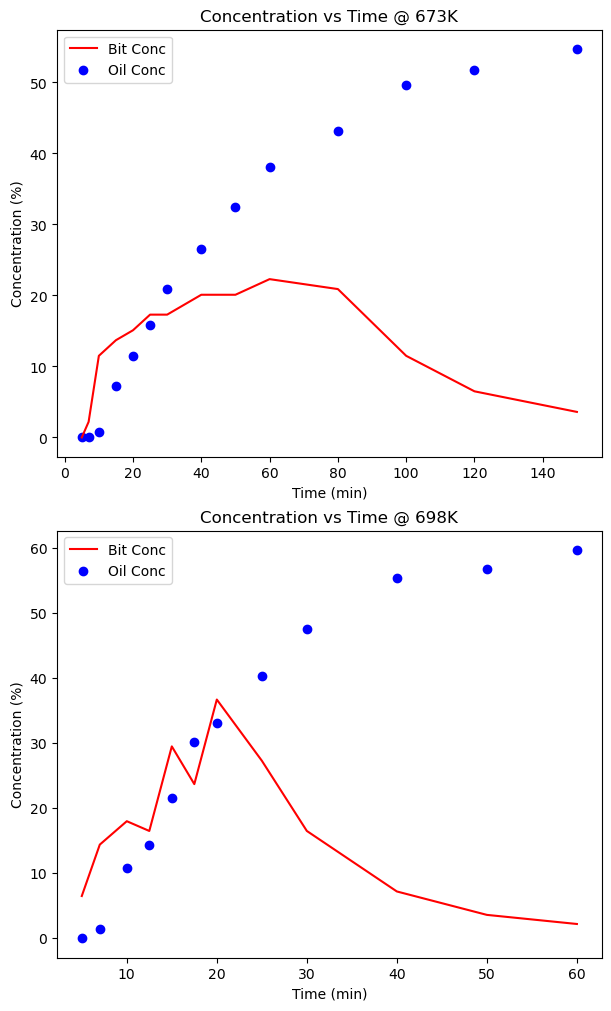

In [4]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,10), constrained_layout=True)  # figsize is the size of the whole figure, not the size of each subplots
#plt.figure(figsize=(10,10))
ax1.plot(data_673K['Time'], data_673K["Bitumin_Concentration"], color="r", label="Bit Conc")
ax1.scatter(data_673K['Time'], data_673K["Oil_Concentration"], color ="b", label="Oil Conc")
ax1.legend()
ax1.set_xlabel("Time (min)")
ax1.set_ylabel("Concentration (%)")
ax1.set_title("Concentration vs Time @ 673K")

ax2.plot(data_698K['Time'], data_698K["Bitumin_Concentration"], color="r", label="Bit Conc")
ax2.scatter(data_698K['Time'], data_698K["Oil_Concentration"], color ="b", label="Oil Conc")
ax2.legend()
ax2.set_xlabel("Time (min)")
ax2.set_ylabel("Concentration (%)")
ax2.set_title("Concentration vs Time @ 698K")


# Model / Class

In [42]:
# Initial Estimates of the parameters
"""
at t = 0, Ck = 100. from this we can get the initial rate of the 
reaction and find the initial guess for the parameters, ``thetas``
"""
theta_10 = 0.031
theta_20 = 0.0131
theta_30 = 0.0286
theta_40 = 0.013

In [16]:
data_673K

,Temperature,Time,Bitumin_Concentration,Oil_Concentration
0,673,5,0.0,0.0
1,673,7,2.2,0.0
2,673,10,11.5,0.7
3,673,15,13.7,7.2
4,673,20,15.1,11.5
5,673,25,17.3,15.8
6,673,30,17.3,20.9
7,673,40,20.1,26.6
8,673,50,20.1,32.4
9,673,60,22.3,38.1


In [32]:
class OilShale(Experiment):
    def __init__(self, data, theta_initial=None, conc_err=3, nfe=30, ncp=3):
        """
        Arguments:
            data -> experiment data, type: pandas ``dataframe`` or ``dict``
            theta_initial -> initail estimate of our parameter values. type: pandas ``dataframe``
            conc_err -> concentration measurement error. default: 3%
            nfe -> Number of finite elements. 
            ncp -> Number of collocation points
        """
        self.data = data
        self.theta_initial = theta_initial
        self.model = None
        self.nfe = nfe
        self.ncp = ncp
        self.conc_err = conc_err  # Error in concentration measurement
        
        if self.theta_initial is None:
            self.theta_initial = {
                "theta_10": 0.031,
                "theta_20": 0.0131,
                "theta_30" : 0.0286,
                "theta_40" : 0.013
            }

    # Creating the ``get_labeled_model``
    def get_labeled_model(self):
        if self.model is None:
            self.create_model()
            self.label_model()
            self.finalize_model()
            return self.model

                
    #++++++++++++++++++++++++++++++++++++++
    #  create_model
    def create_model(self):
        """
        Here, we will create different variables, parameters, and constraints
        """            
        m = self.model = pyo.ConcreteModel()

        # Set (time)
        m.t = ContinuousSet(initialize=sorted(set([0, 150] + list(self.data["Time"]))))
        # m.t = ContinuousSet(bounds=(0,150))

        # Parameters
        m.theta_1 = pyo.Var(bounds=(0, 1), initialize= self.theta_initial["theta_10"])
        m.theta_2 = pyo.Var(bounds=(0, 1), initialize= self.theta_initial["theta_20"])
        m.theta_3 = pyo.Var(bounds=(0, 1), initialize= self.theta_initial["theta_30"])
        m.theta_4 = pyo.Var(bounds=(0, 1), initialize= self.theta_initial["theta_40"])

        # State Variables
        m.G1 = pyo.Var(m.t, domain=pyo.NonNegativeReals)  # kerogen concentration, gamma_1
        m.G2 = pyo.Var(m.t, domain=pyo.NonNegativeReals)  # Bitumen concentration, gamma_2
        m.G3 = pyo.Var(m.t, domain=pyo.NonNegativeReals)  # Oil concentration, gamma_3

        # Differential variables
        m.dG1dt = DerivativeVar(m.G1, wrt=m.t)
        m.dG2dt = DerivativeVar(m.G2, wrt=m.t)
        m.dG3dt = DerivativeVar(m.G3, wrt=m.t)

        # Constraints
        @m.Constraint(m.t)
        def kerogen_consum_rate(m, t):   # kerogen consumption rate
            return m.dG1dt[t] == -(m.theta_1 + m.theta_4) * m.G1[t]

        @m.Constraint(m.t)
        def bitumen_rxn_rate(m, t):
            return m.dG2dt[t] == m.theta_1 * m.G1[t] - (m.theta_2 + m.theta_3) * m.G2[t]

        @m.Constraint(m.t)
        def oil_gen_rate(m, t):
            return m.dG3dt[t] == m.theta_4 * m.G1[t] + m.theta_2 * m.G2[t]
        
        m.pprint()

        return m
        
    #++++++++++++++++++++++++++++++++++++++
    def finalize_model(self):
        """
        Finalizing the model. Here, we will set the experimental conditions (e.g, initial conditions),
        fixing the parameter values (if needed), update `t` values, and discretize the model (if model is dynamic). 
        It makes a solvable model.
        """
        m = self.model

        # fixing the parameter values
        m.theta_1.fix(self.theta_initial["theta_10"])
        m.theta_2.fix(self.theta_initial["theta_20"])
        m.theta_3.fix(self.theta_initial["theta_30"])
        m.theta_4.fix(self.theta_initial["theta_40"])

        # Setting the initial condition
        m.G1[0].fix(100)
        m.G2[0].fix(0)
        m.G3[0].fix(0)

        # Discretizing the model
        discr = pyo.TransformationFactory("dae.collocation")
        discr.apply_to(m, nfe=self.nfe, ncp=self.ncp, wrt=m.t)

        return m
  
    #++++++++++++++++++++++++++++++++++++++
    def label_model(self):
        """
        The model is updated with experimental outputs, inputs, errors and unknown parameters
        This makes the model labeled with full experiment
        """
        m = self.model

        m.t_control = self.data["Time"]

        # Experimental outputs
        m.experiment_outputs = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        m.experiment_outputs.update((m.G1[t], None) for t in self.data["Time"])
        m.experiment_outputs.update((m.G2[t], self.data.iloc[ind]["Bitumin_Concentration"]) for ind, t in enumerate(self.data["Time"]))
        m.experiment_outputs.update((m.G3[t], self.data.iloc[ind]["Oil_Concentration"]) for ind, t in enumerate(self.data["Time"]))
        
        # Experimental inputs
        m.experiment_inputs = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        m.experiment_inputs[m.G1[m.t.first()]] = None

        # Experimental Measurement Error
        m.measurement_error = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        m.measurement_error.update((m.G1[float(t)], self.conc_err) for t in self.data["Time"])
        m.measurement_error.update((m.G2[t], self.conc_err) for t in self.data["Time"])
        m.measurement_error.update((m.G3[t], self.conc_err) for t in self.data["Time"])
        

        # Unknown parameters
        m.unknown_parameters = pyo.Suffix(direction = pyo.Suffix.LOCAL)
        m.unknown_parameters.update((k, pyo.value(k)) for k in [m.theta_1, m.theta_2, m.theta_3, m.theta_4])

        return m    
    
    #++++++++++++++++++++++++++++++++++++++
        

## Parmest Object

In [21]:
data_673K

,Temperature,Time,Bitumin_Concentration,Oil_Concentration
0,673,5,0.0,0.0
1,673,7,2.2,0.0
2,673,10,11.5,0.7
3,673,15,13.7,7.2
4,673,20,15.1,11.5
5,673,25,17.3,15.8
6,673,30,17.3,20.9
7,673,40,20.1,26.6
8,673,50,20.1,32.4
9,673,60,22.3,38.1


## DOE Example

In [33]:
def run_reacton_doe():
    experiment = OilShale(data_673K)

    doe_obj = DesignOfExperiments(
        experiment, 
        tee=True
    )

    print("FIM of the experiment:\n", doe_obj.compute_FIM())

run_reacton_doe()
    

7 Var Declarations
    G1 : Size=15, Index=t
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :  None : False :  True : NonNegativeReals
          5 :     0 :  None :  None : False :  True : NonNegativeReals
          7 :     0 :  None :  None : False :  True : NonNegativeReals
         10 :     0 :  None :  None : False :  True : NonNegativeReals
         15 :     0 :  None :  None : False :  True : NonNegativeReals
         20 :     0 :  None :  None : False :  True : NonNegativeReals
         25 :     0 :  None :  None : False :  True : NonNegativeReals
         30 :     0 :  None :  None : False :  True : NonNegativeReals
         40 :     0 :  None :  None : False :  True : NonNegativeReals
         50 :     0 :  None :  None : False :  True : NonNegativeReals
         60 :     0 :  None :  None : False :  True : NonNegativeReals
         80 :     0 :  None :  None : False :  True : NonNegativeReals
        100 :     0 :  None :  None : Fals

In [25]:
data_673K.iloc[1,2]

np.float64(2.2)